# Infering using the Dirichlet Process Method from scikit-learn
## <font color='red'> Assumption: The data gives an indication of the underlying distributions <b> and </b> number of clusters. </font>

The Jupyter Notebooks 2DBayesianMixture and InferBayesianMixture, as well as ChineseRestaurantProcess and InferDirichletProcess are intended to illustrate the mechanisms in generating the data and how to estimate the parameters of the processes generating the data, once the data has been seen. Of course, scikit-learn already has implementations and their use is illustrated here.

## Import modules

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn import mixture

## Load data

In [2]:
npzfile = np.load('GaussianMixture.npz')
n_dim = len(npzfile.files) - 1
print(n_dim)
print(npzfile.files)

2
['x_sample', 'y_sample', 'mixing_idx']


## Plot data
The information which component generated which sample is deliberately not plotted.

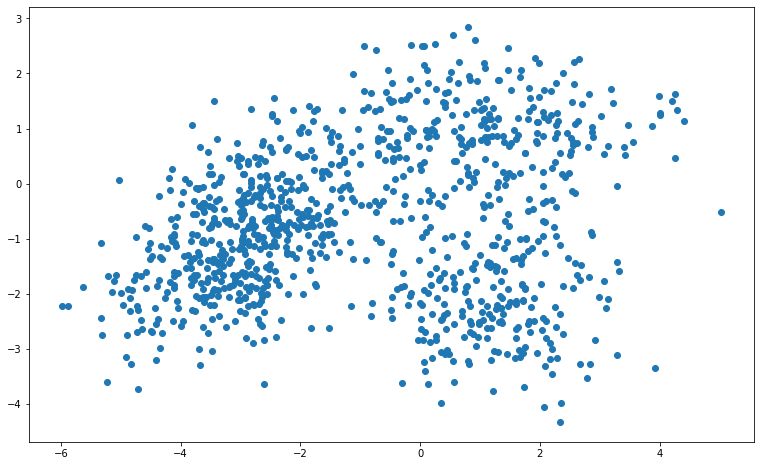

In [3]:
x_sample = npzfile['x_sample']
y_sample = npzfile['y_sample']
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample)
plt.show()

### Initialize priors
The priors are chosen to be uninformative. The hyperparameter $\alpha$ is set to larger than $0.5$ meaning generation of new clusters is slightly favoured. The *location vector* $\mathbf{m}$ is initialized to the mean of the all data samples. The *mean fraction* $\lambda$ is intialized to $1$ supporting the assumption that the clusters overlay. The *inverse scale matrix* $\boldsymbol{\Psi}$ is initialized to the average squared distance from mean in each dimension times the identity. The degrees of freedom $\nu$ is set to the number of dimensions. This is most uninformative.

In [4]:
data = np.stack((x_sample, y_sample)).T
max_comp = 7
alpha0 = 0.7
mean0 = np.mean(data,0)
lambda0 = 1
scale0 = np.sum(np.square(data - mean0))/len(data) * np.identity(n_dim)
df0 = n_dim

## Dirichlet Process Method


In [5]:
bgm = mixture.BayesianGaussianMixture(n_components=max_comp, covariance_type='full', init_params='random', 
                                      weight_concentration_prior_type = 'dirichlet_process',
                                      weight_concentration_prior = alpha0, mean_prior = mean0, 
                                      mean_precision_prior = lambda0, covariance_prior = scale0, 
                                      degrees_of_freedom_prior= df0)
idx = bgm.fit_predict(data)

#### Results
The data was generated mixing three normal distributions, 
\begin{equation}
\mathcal{N}\left( \left( {-3} \atop {-1} \right), \left( 1 \atop 0.5 \right. \left. 0.5 \atop 1 \right) \right), \mathcal{N}\left( \left( 1 \atop 1 \right), \left( 2 \atop 0 \right. \left. 0 \atop 0.5 \right) \right), \mathcal{N}\left( \left( 1 \atop {-2} \right), \left( 1 \atop 0 \right. \left. 0 \atop 1 \right) \right).
\end{equation}
with mixing coefficients 0.5, 0.25 and 0.25. 

In [6]:
weights = bgm.weights_
order = np.flip(np.argsort(weights))
print(order)
colours =  [(1,0,0), (0,1,0), (0,0,1), (1,1,0), (0,1,1), (1,0,1), (0,0,0)]
c = np.zeros((len(idx),3))
print('Mixing coefficients: ', weights[order], '\n')
for i,j in enumerate(order):
    c[idx==j,:] = colours[i]
    print('Component', i+1)
    print('Mean:', bgm.means_[j])
    print('Covariance:', bgm.covariances_[j], '\n')

[0 4 1 2 3 5 6]
Mixing coefficients:  [5.03068277e-01 2.60502608e-01 2.33731471e-01 1.05808947e-03
 1.05267767e-03 4.16613054e-04 1.70263583e-04] 

Component 1
Mean: [-2.92056266 -0.95723364]
Covariance: [[1.11660752 0.50798568]
 [0.50798568 1.03560732]] 

Component 2
Mean: [1.0364887  0.94250545]
Covariance: [[ 1.96529563 -0.00388495]
 [-0.00388495  0.62076617]] 

Component 3
Mean: [ 1.12669147 -2.04839877]
Covariance: [[ 1.01426211 -0.08920384]
 [-0.08920384  0.81404709]] 

Component 4
Mean: [-0.92283977 -0.70908816]
Covariance: [[3.66731196 0.0048528 ]
 [0.0048528  3.63181189]] 

Component 5
Mean: [-0.92303731 -0.70915111]
Covariance: [[3.66742216 0.0047475 ]
 [0.0047475  3.63269434]] 

Component 6
Mean: [-0.9289823  -0.71106026]
Covariance: [[3.67134433e+00 9.94295137e-04]
 [9.94295137e-04 3.66407421e+00]] 

Component 7
Mean: [-0.93017466 -0.71144281]
Covariance: [[3.67213444e+00 2.31696310e-04]
 [2.31696310e-04 3.67044045e+00]] 



#### Plot data 
First coloured by sampled cluster assignments. 

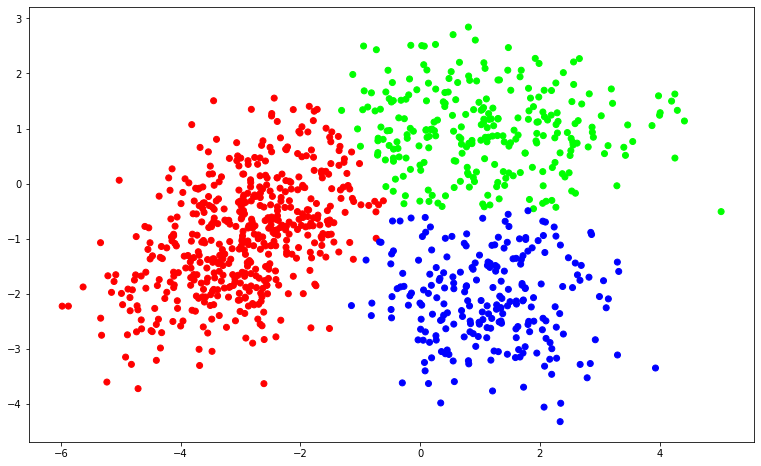

In [7]:
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample, c = c)
plt.show()

Secondly, each sample is given a colour mixed from red, green and blue according to the estimated posterior assignment probabilities, also known as *responsibilities* of the *three largest* clusters. The regions where we have a mix of colours are those where the responsibilities are *not* clearly favouring one cluster. This also explains the incorrect assignments in the previous plot.

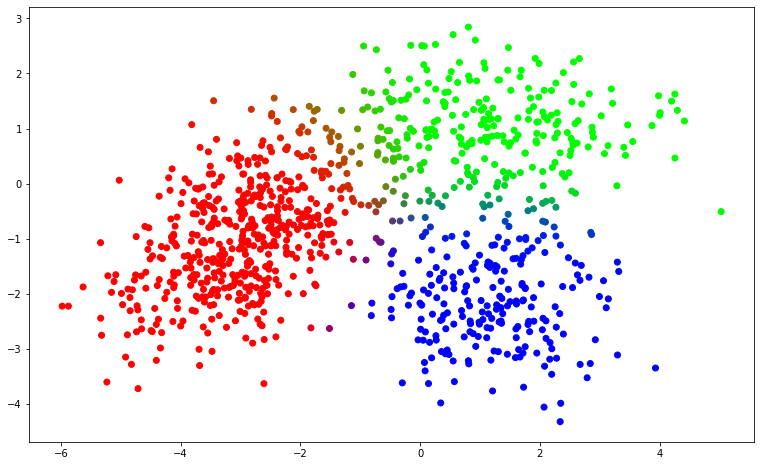

In [8]:
fig = plt.figure(figsize=(13,8))
p = bgm.predict_proba(data)
c = p[:,order[0:3]] 
plt.scatter(x_sample, y_sample, c = c)
plt.show()